### File Explanation

**trainRNN_HBTRC_StaticModel_dropout.ipynb:**
<br> This notebook is to load HBTRC examples from 'preprocessData_HBTRC.pickle', create a "Static Network" and train the network with respect to a range of dropout rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer static model (function: **LSTM_Model** in **trainRNN_network_utils.py**)
<br> 5) Create a single normalised output by using the last outputs of static models of gene A and gene B (function: **batch_normalised_sum** in **trainRNN_network_utils.py**)
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 7) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 8) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 9) Save them in "resultsStaticDropout_HBTRC.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])

In [17]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData_HBTRC.ipynb"

# Save data into Python file
import pickle
with open('preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    sGeneNames_tr_nX2 = pickle.load( f )
    sGeneNames_tst_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data saved into pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [7]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropouts = [0.4, 0.5, 0.6, 0.7, 0.8]                # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 100
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches

### Network and Train

In [13]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
for dropout in dropouts:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])
        init_state_A = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

        hidden_output_A, current_state_A = LSTM_Model(rSnpRnaA_pXNS, 
                                                      init_state_A, 
                                                      n_layer, 
                                                      n_hidden, 
                                                      dropout)

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])
        init_state_B = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

        hidden_output_B, current_state_B = LSTM_Model(rSnpRnaB_pXNS, 
                                                      init_state_B, 
                                                      n_layer, 
                                                      n_hidden,
                                                      dropout)

    hidden_output = batch_normalised_sum(hidden_output_A, hidden_output_B)

    ## Output placeholder
    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')

    # Dense Layer
    logit = tf.layers.dense( hidden_output,
                            units = n_classes, 
                            activation = None,
                            kernel_initializer = tf.initializers.random_normal() ) 

    prediction = tf.nn.softmax( logit )

    ## Loss and optimiser
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                         labels=tf.argmax(rRelated_pXC,1)))

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            # Initial current_state
            _current_state_A = np.zeros((n_layer, 2, batch_size, n_hidden))
            _current_state_B = np.zeros((n_layer, 2, batch_size, n_hidden))
            _current_state_tst_A = np.zeros((n_layer, 2, rSnpA_tst_nXSN.shape[0], n_hidden))
            _current_state_tst_B = np.zeros((n_layer, 2, rSnpA_tst_nXSN.shape[0], n_hidden))

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC,
                        init_state_A: _current_state_A,                      
                        init_state_B: _current_state_B,                       
                    })

                tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC,
                        init_state_A: _current_state_tst_A,                      
                        init_state_B: _current_state_tst_B,
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
            
        trainLosses[dropout] = train_losses
        testLosses[dropout] = test_losses
        trainAccuracy[dropout] = train_accuracies
        F1_scores[dropout] = test_f1_score
        print("Optimisation finished!")



Data shuffled. Epoch:  0
Performance on training data: Loss = 1.093000888824463: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.0902198553085327: Accuracy = 0.5264750488523348

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.1005206108093262: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.0754566192626953: Accuracy = 0.6373626019541465

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.1102423667907715: Accuracy = 0.33000001311302185
Performance on test set: : Loss = 1.0687322616577148: Accuracy = 0.6533166146725526

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.10637629032135: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.094265341758728: Accuracy = 0.6445203586545801

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.0720298290252686: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.0779626369476318: Accuracy = 0.6499023541105755

Data shuffled. Epo

Performance on training data: Loss = 0.8840838670730591: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.062633991241455: Accuracy = 0.4296863478031596

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.8994256854057312: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.0643095970153809: Accuracy = 0.4340803509437067

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.9266035556793213: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.0704963207244873: Accuracy = 0.4382638650491947

Data shuffled. Epoch:  45
Performance on training data: Loss = 0.8855536580085754: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.0700291395187378: Accuracy = 0.44225158764143496

Data shuffled. Epoch:  46
Performance on training data: Loss = 0.906818687915802: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.097011923789978: Accuracy = 0.44602604358632947

Data shuffled. Epoch:  47
Performance

Performance on training data: Loss = 1.0892257690429688: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.0749348402023315: Accuracy = 0.5747811248033378

Data shuffled. Epoch:  85
Performance on training data: Loss = 1.0656293630599976: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.039896845817566: Accuracy = 0.5774046849535146

Data shuffled. Epoch:  86
Performance on training data: Loss = 1.0516468286514282: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.07758367061615: Accuracy = 0.5797717595055899

Data shuffled. Epoch:  87
Performance on training data: Loss = 1.0536694526672363: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.068102478981018: Accuracy = 0.5828359205363117

Data shuffled. Epoch:  88
Performance on training data: Loss = 1.010002851486206: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.0811282396316528: Accuracy = 0.5843234592093898

Data shuffled. Epoch:  89
Performance o

Performance on training data: Loss = 1.0140691995620728: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.1860696077346802: Accuracy = 0.5803006059983934

Data shuffled. Epoch:  127
Performance on training data: Loss = 1.0377662181854248: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.155364751815796: Accuracy = 0.5820473594773864

Data shuffled. Epoch:  128
Performance on training data: Loss = 1.0559234619140625: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.160860300064087: Accuracy = 0.5837202086971003

Data shuffled. Epoch:  129
Performance on training data: Loss = 1.050270676612854: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.170583963394165: Accuracy = 0.5842398112287573

Data shuffled. Epoch:  130
Performance on training data: Loss = 0.8969244956970215: Accuracy = 0.6499999761581421
Performance on test set: : Loss = 1.1235228776931763: Accuracy = 0.5841284109257486

Data shuffled. Epoch:  131
Perfor

Performance on training data: Loss = 1.000820517539978: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.169575810432434: Accuracy = 0.5449797123185174

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.9274899363517761: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.180197834968567: Accuracy = 0.5450509817825678

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.912040650844574: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.2294676303863525: Accuracy = 0.5444950286204194

Data shuffled. Epoch:  171
Performance on training data: Loss = 0.8721686005592346: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.1774736642837524: Accuracy = 0.5433782273826491

Data shuffled. Epoch:  172
Performance on training data: Loss = 0.9417274594306946: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.1816070079803467: Accuracy = 0.5422266149329187

Data shuffled. Epoch:  173
Performan

Performance on training data: Loss = 0.9747498035430908: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.2087982892990112: Accuracy = 0.517127060247952

Data shuffled. Epoch:  11
Performance on training data: Loss = 0.9389243125915527: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.2163037061691284: Accuracy = 0.49169665714096134

Data shuffled. Epoch:  12
Performance on training data: Loss = 0.9835525751113892: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.2153562307357788: Accuracy = 0.4686432040448025

Data shuffled. Epoch:  13
Performance on training data: Loss = 0.9564298987388611: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.2166856527328491: Accuracy = 0.4476609812767105

Data shuffled. Epoch:  14
Performance on training data: Loss = 1.0295219421386719: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.2203950881958008: Accuracy = 0.42744117655001446

Data shuffled. Epoch:  15
Performan

Performance on training data: Loss = 1.0261025428771973: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.2031102180480957: Accuracy = 0.31415090975394444

Data shuffled. Epoch:  53
Performance on training data: Loss = 0.938974916934967: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.2153785228729248: Accuracy = 0.3100524911743325

Data shuffled. Epoch:  54
Performance on training data: Loss = 0.9673234820365906: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.195953607559204: Accuracy = 0.3058595873229687

Data shuffled. Epoch:  55
Performance on training data: Loss = 0.9652267694473267: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.2152588367462158: Accuracy = 0.30203530659976596

Data shuffled. Epoch:  56
Performance on training data: Loss = 0.9852957129478455: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.2158324718475342: Accuracy = 0.2985237429796064

Data shuffled. Epoch:  57
Performanc

Performance on training data: Loss = 1.1052429676055908: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.130752682685852: Accuracy = 0.35343743695142615

Data shuffled. Epoch:  95
Performance on training data: Loss = 1.1128649711608887: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.1105154752731323: Accuracy = 0.36181209265406966

Data shuffled. Epoch:  96
Performance on training data: Loss = 1.0751720666885376: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.12565016746521: Accuracy = 0.3687512521189519

Data shuffled. Epoch:  97
Performance on training data: Loss = 1.100010871887207: Accuracy = 0.33000001311302185
Performance on test set: : Loss = 1.1074634790420532: Accuracy = 0.37466941110914814

Data shuffled. Epoch:  98
Performance on training data: Loss = 1.088610053062439: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.0910661220550537: Accuracy = 0.37850804711598396

Data shuffled. Epoch:  99
Performan

Performance on training data: Loss = 1.0760345458984375: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.099661946296692: Accuracy = 0.48817827578437284

Data shuffled. Epoch:  137
Performance on training data: Loss = 1.0628201961517334: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.098697543144226: Accuracy = 0.48994083967894675

Data shuffled. Epoch:  138
Performance on training data: Loss = 1.1071432828903198: Accuracy = 0.25
Performance on test set: : Loss = 1.1073472499847412: Accuracy = 0.4915764844410131

Data shuffled. Epoch:  139
Performance on training data: Loss = 1.0743707418441772: Accuracy = 0.3199999928474426
Performance on test set: : Loss = 1.1115119457244873: Accuracy = 0.4929645369286524

Data shuffled. Epoch:  140
Performance on training data: Loss = 1.0567530393600464: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.1014931201934814: Accuracy = 0.4949564593962727

Data shuffled. Epoch:  141
Performance on tr

Performance on training data: Loss = 0.8861177563667297: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.042479395866394: Accuracy = 0.5708551796264338

Data shuffled. Epoch:  179
Performance on training data: Loss = 0.9472076892852783: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.0423887968063354: Accuracy = 0.5726222468353723

Data shuffled. Epoch:  180
Performance on training data: Loss = 0.8859639167785645: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.0578488111495972: Accuracy = 0.5742592301808807

Data shuffled. Epoch:  181
Performance on training data: Loss = 0.8999730944633484: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.032984972000122: Accuracy = 0.5759455829036634

Data shuffled. Epoch:  182
Performance on training data: Loss = 0.9223945140838623: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.0446146726608276: Accuracy = 0.5777333687655554

Data shuffled. Epoch:  183
Perform

Performance on training data: Loss = 1.1537092924118042: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.2328633069992065: Accuracy = 0.5024675837536164

Data shuffled. Epoch:  21
Performance on training data: Loss = 1.0700793266296387: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.2062304019927979: Accuracy = 0.4894024257771265

Data shuffled. Epoch:  22
Performance on training data: Loss = 1.048912763595581: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.19975745677948: Accuracy = 0.47745294189044063

Data shuffled. Epoch:  23
Performance on training data: Loss = 1.0412380695343018: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.2179372310638428: Accuracy = 0.4660451038395571

Data shuffled. Epoch:  24
Performance on training data: Loss = 1.0749366283416748: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.2206742763519287: Accuracy = 0.4555334512231064

Data shuffled. Epoch:  25
Performance

Performance on training data: Loss = 1.078611135482788: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.0549482107162476: Accuracy = 0.4568837725817244

Data shuffled. Epoch:  63
Performance on training data: Loss = 1.0503573417663574: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.0964418649673462: Accuracy = 0.4619845136140943

Data shuffled. Epoch:  64
Performance on training data: Loss = 1.008070707321167: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.1072877645492554: Accuracy = 0.46364481985326006

Data shuffled. Epoch:  65
Performance on training data: Loss = 0.9776343703269958: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1062661409378052: Accuracy = 0.4617756824887291

Data shuffled. Epoch:  66
Performance on training data: Loss = 0.9703201055526733: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.158101201057434: Accuracy = 0.4642982872594841

Data shuffled. Epoch:  67
Performance

Performance on training data: Loss = 0.9219880700111389: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1417726278305054: Accuracy = 0.5497628062813987

Data shuffled. Epoch:  105
Performance on training data: Loss = 0.9771085381507874: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.1628358364105225: Accuracy = 0.5493721964381056

Data shuffled. Epoch:  106
Performance on training data: Loss = 0.9483517408370972: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.17698073387146: Accuracy = 0.5480338017079072

Data shuffled. Epoch:  107
Performance on training data: Loss = 1.0589420795440674: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.1660510301589966: Accuracy = 0.5490947836213806

Data shuffled. Epoch:  108
Performance on training data: Loss = 0.9451346397399902: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1624892950057983: Accuracy = 0.5504996601843745

Data shuffled. Epoch:  109
Perfo

Performance on training data: Loss = 0.9867297410964966: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.1921141147613525: Accuracy = 0.584045418230777

Data shuffled. Epoch:  147
Performance on training data: Loss = 0.9714002013206482: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.123574137687683: Accuracy = 0.5856265523371857

Data shuffled. Epoch:  148
Performance on training data: Loss = 0.9907757639884949: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.110261082649231: Accuracy = 0.5872482321551528

Data shuffled. Epoch:  149
Performance on training data: Loss = 0.9123488664627075: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1704730987548828: Accuracy = 0.5888829062052842

Data shuffled. Epoch:  150
Performance on training data: Loss = 0.9773415327072144: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.163544774055481: Accuracy = 0.5905551536175505

Data shuffled. Epoch:  151
Performan

Performance on training data: Loss = 0.87983238697052: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.1206262111663818: Accuracy = 0.6272431684766518

Data shuffled. Epoch:  189
Performance on training data: Loss = 0.9536065459251404: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.0843805074691772: Accuracy = 0.6275366100924664

Data shuffled. Epoch:  190
Performance on training data: Loss = 0.9168623089790344: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.1343730688095093: Accuracy = 0.6278313082081018

Data shuffled. Epoch:  191
Performance on training data: Loss = 0.9121963381767273: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1045973300933838: Accuracy = 0.6280058509339795

Data shuffled. Epoch:  192
Performance on training data: Loss = 0.9011143445968628: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.1019387245178223: Accuracy = 0.6281945153996756

Data shuffled. Epoch:  193
Perform

Performance on training data: Loss = 1.1165449619293213: Accuracy = 0.2800000011920929
Performance on test set: : Loss = 1.0937724113464355: Accuracy = 0.7041211607201049

Data shuffled. Epoch:  31
Performance on training data: Loss = 1.1020201444625854: Accuracy = 0.3199999928474426
Performance on test set: : Loss = 1.0301086902618408: Accuracy = 0.7050469182147291

Data shuffled. Epoch:  32
Performance on training data: Loss = 1.0964455604553223: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.1130632162094116: Accuracy = 0.7022399045449939

Data shuffled. Epoch:  33
Performance on training data: Loss = 1.047989010810852: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.052253007888794: Accuracy = 0.7007927956830301

Data shuffled. Epoch:  34
Performance on training data: Loss = 1.0627325773239136: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.0823585987091064: Accuracy = 0.6994285911993228

Data shuffled. Epoch:  35
Performanc

Performance on training data: Loss = 0.9653023481369019: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.0898014307022095: Accuracy = 0.6590138514872058

Data shuffled. Epoch:  73
Performance on training data: Loss = 1.0221575498580933: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.1154297590255737: Accuracy = 0.660901035177757

Data shuffled. Epoch:  74
Performance on training data: Loss = 0.9763611555099487: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.107580304145813: Accuracy = 0.6632047626822744

Data shuffled. Epoch:  75
Performance on training data: Loss = 0.985596239566803: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.1153517961502075: Accuracy = 0.6655526396649594

Data shuffled. Epoch:  76
Performance on training data: Loss = 1.0088098049163818: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.1199421882629395: Accuracy = 0.6677917956548702

Data shuffled. Epoch:  77
Performance o

Performance on training data: Loss = 0.8789824843406677: Accuracy = 0.6499999761581421
Performance on test set: : Loss = 1.1558417081832886: Accuracy = 0.6329890458373667

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.8909121155738831: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.173540711402893: Accuracy = 0.6312656694491369

Data shuffled. Epoch:  116
Performance on training data: Loss = 0.8916871547698975: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.214902639389038: Accuracy = 0.6292500396376023

Data shuffled. Epoch:  117
Performance on training data: Loss = 0.8957275152206421: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.2305140495300293: Accuracy = 0.6265549585759678

Data shuffled. Epoch:  118
Performance on training data: Loss = 0.8814681172370911: Accuracy = 0.6499999761581421
Performance on test set: : Loss = 1.2103631496429443: Accuracy = 0.6238726334135324

Data shuffled. Epoch:  119
Perform

Performance on training data: Loss = 0.8879393935203552: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.090191125869751: Accuracy = 0.6189767252271519

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.8645530939102173: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.1062103509902954: Accuracy = 0.6201539773798733

Data shuffled. Epoch:  158
Performance on training data: Loss = 0.8969240784645081: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.1136072874069214: Accuracy = 0.6213019823743392

Data shuffled. Epoch:  159
Performance on training data: Loss = 0.9161306023597717: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1164333820343018: Accuracy = 0.6224168052400942

Data shuffled. Epoch:  160
Performance on training data: Loss = 0.9294624328613281: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1054441928863525: Accuracy = 0.623519058935937

Data shuffled. Epoch:  161
Perform

Performance on training data: Loss = 0.9723585247993469: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.1817165613174438: Accuracy = 0.6475432793888471

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.8706818222999573: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.2358577251434326: Accuracy = 0.6461616771571351

Optimisation finished!
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.0987602472305298: Accuracy = 0.3199999928474426
Performance on test set: : Loss = 1.118959903717041: Accuracy = 0.6627358439662686

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.1013277769088745: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.099190354347229: Accuracy = 0.6723355895510799

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.09424889087677: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.112975001335144: Accuracy = 0.6625954808218003

Data shuffled. Epoc

Performance on training data: Loss = 0.93337082862854: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1755101680755615: Accuracy = 0.48887907474345366

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.8807474374771118: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.1668802499771118: Accuracy = 0.48518914980532846

Data shuffled. Epoch:  42
Performance on training data: Loss = 0.8821620345115662: Accuracy = 0.6700000166893005
Performance on test set: : Loss = 1.0675036907196045: Accuracy = 0.48551286477066496

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.8881241679191589: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.0907106399536133: Accuracy = 0.4873526787758119

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.8865955471992493: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.0719847679138184: Accuracy = 0.48833286041132246

Data shuffled. Epoch:  45
Performa

Performance on training data: Loss = 0.8790578246116638: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.157132625579834: Accuracy = 0.39934087922802086

Data shuffled. Epoch:  83
Performance on training data: Loss = 0.902080774307251: Accuracy = 0.6700000166893005
Performance on test set: : Loss = 1.197056770324707: Accuracy = 0.39624792338512654

Data shuffled. Epoch:  84
Performance on training data: Loss = 0.8733134269714355: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.1728986501693726: Accuracy = 0.3953795588804251

Data shuffled. Epoch:  85
Performance on training data: Loss = 0.9417275786399841: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.0913398265838623: Accuracy = 0.39636697367552554

Data shuffled. Epoch:  86
Performance on training data: Loss = 0.8932615518569946: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.1811789274215698: Accuracy = 0.39615656096529145

Data shuffled. Epoch:  87
Performanc

Performance on training data: Loss = 1.105980634689331: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.247207522392273: Accuracy = 0.3724150747356973

Data shuffled. Epoch:  125
Performance on training data: Loss = 1.1327687501907349: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.18613600730896: Accuracy = 0.3718212402368924

Data shuffled. Epoch:  126
Performance on training data: Loss = 1.1319464445114136: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.200499176979065: Accuracy = 0.37125604745221746

Data shuffled. Epoch:  127
Performance on training data: Loss = 1.1479449272155762: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.183683156967163: Accuracy = 0.37083273083373275

Data shuffled. Epoch:  128
Performance on training data: Loss = 1.2252649068832397: Accuracy = 0.30000001192092896
Performance on test set: : Loss = 1.179895281791687: Accuracy = 0.3702805572949354

Data shuffled. Epoch:  129
Performan

Performance on training data: Loss = 1.069178819656372: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.0151933431625366: Accuracy = 0.4851352359058047

Data shuffled. Epoch:  167
Performance on training data: Loss = 1.0601614713668823: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.1012481451034546: Accuracy = 0.48820951610961594

Data shuffled. Epoch:  168
Performance on training data: Loss = 1.0652788877487183: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.0553860664367676: Accuracy = 0.4912240824858979

Data shuffled. Epoch:  169
Performance on training data: Loss = 1.0642333030700684: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.0312880277633667: Accuracy = 0.49430382286559116

Data shuffled. Epoch:  170
Performance on training data: Loss = 1.0494858026504517: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.0400805473327637: Accuracy = 0.4971829950239058

Data shuffled. Epoch:  171
P

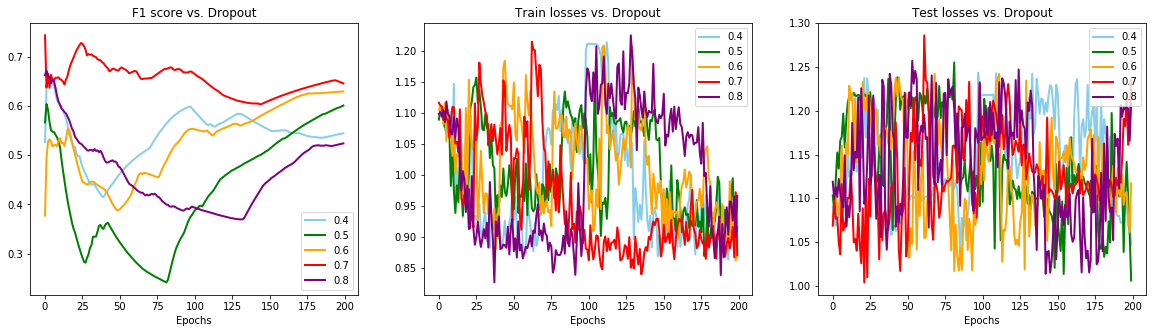

In [18]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Dropout")

In [20]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsStaticDropout_HBTRC.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
